**Pouya Sadeghi**

winter-1401(2022)

# AI course, project #5-2

**Neural Network**

In this notebook, we would use Keras and Tensorflow to implement FFNN.

# 00. Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
import tensorflow.keras.activations as activation
from sklearn.metrics import classification_report

import random

In [2]:
dataset = keras.datasets.cifar10.load_data()

train_dataset, test_dataset = dataset
x_train, y_train = train_dataset
x_test, y_test = test_dataset

# 01. Phase 1: Data preprocessing and visualization

In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
label_translation = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 
    4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse',
    8: 'ship', 9: 'truck'
} 

In [5]:
def show_images(data: np.ndarray, labels, label_translation: dict):
    values = list(np.unique(y_train))
    v_count = len(values)
    nrow = max(2,(v_count+4)//5)
    fig, ax = plt.subplots(nrow, 5, figsize=(13, 5*(nrow//2)))
    for idx, v in enumerate(values):
        ax[idx//5][idx%5].set_title(label_translation[v])
        img_idx = random.choice(np.where(labels == v)[0])
        img = np.reshape(data[img_idx], (32, 32, 3))
        ax[idx//5][idx%5].imshow(img, aspect='auto')
    plt.show()


## Reshape (+flatten)

In [6]:
x_train, x_test = x_train.reshape(-1, 32*32*3), x_test.reshape(-1, 32*32*3)
y_train, y_test = y_train.flatten(), y_test.flatten()

## Normalization

In [7]:
x_train, x_test = x_train / 255.0, x_test / 255.0

## Visualization

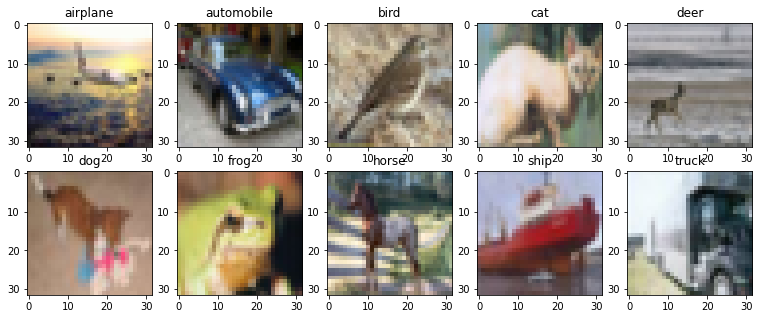

In [8]:
show_images(x_train, y_train, label_translation)

## Label frequencies

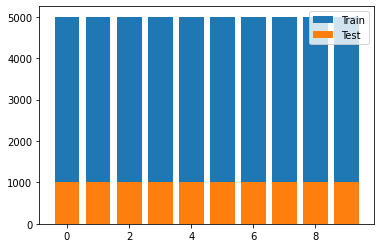

In [9]:
val, count = np.unique(y_train, return_counts=True)
t_val, t_count = np.unique(y_test, return_counts=True)
plt.bar(val, count, label="Train")
plt.bar(t_val, t_count, label="Test")
plt.legend()
plt.show()

## Label encoding

In [10]:
classes_number = max(len(np.unique(y_train)), len(np.unique(y_test)))

In [11]:
y_train_one_hot = keras.utils.to_categorical(y_train, classes_number)
y_test_one_hot = keras.utils.to_categorical(y_test, classes_number)

# 02. Phase 2: design sequential neural network

Total parameters of each layer:
- $(DimensionOfPreviousLayer(Input|PrevLayerUnits) + 1(bias|CurrLayerUnits)) * DimensionOfCurrentLayer(Weights|CurrLayerUnits)$

In [12]:
labels_count = len(list(np.unique(y_train)))

In [13]:
def generate_model(loss_f=keras.losses.categorical_crossentropy, **config):
    labels_count = len(list(np.unique(y_train)))
    optimizer = config['optimizer']
    units, activations = config['units'], config['activation']
    model = keras.models.Sequential()
    model.add(Input(shape=(32*32*3,)))
    for u, a in zip(units,activations):
        if u is not None: # use a as activation
            model.add(Dense(units=u, activation=a))
        else : # use a as dropout
            model.add(a)
    model.add(Dense(labels_count, activation=activation.softmax))
    
    model.compile(
        optimizer=optimizer, loss=loss_f,
        metrics=['accuracy', 'MeanSquaredError', 'AUC', 
                 keras.metrics.Precision(), keras.metrics.Recall()]
    )
    model.summary()
    
    logs = model.fit(
    x=x_train, y=y_train_one_hot, validation_data=(x_test, y_test_one_hot), 
    batch_size=config['batch_size'], epochs=config['epoch'],
    )
    
    return model, logs

In [14]:
def plot_logs(logs):
    labels = [l for l in logs.history.keys() if 'val_' not in l]
    ll = len(labels)//2
    fig, ax = plt.subplots(ll, 2, figsize=(13, 5*ll))
    
    for idx, l in enumerate(labels):
        i, j = idx%2, idx//2
        ax[j][i].set_title(l.replace('_',' ').title())
        ax[j][i].set_ylabel(l)
        ax[j][i].set_xlabel('Epoch')
        
        ax[j][i].plot(logs.history[f'{l.lower()}'], label="train")
        ax[j][i].plot(logs.history[f'val_{l.lower()}'], label="test")
        ax[j][i].legend()
    
    
    plt.show()
    

In [15]:
def generate_report(model, x_train, y_train, x_test, y_test):
    print(f"{' Train Report ':#^60}")
    y_pred = model.predict(x_train, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    train_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))
    display(HTML(train_report.to_html(index=True)))
    
    print(f"{' Test Report ':#^60}")
    y_pred = model.predict(x_test,verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    test_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    display(HTML(test_report.to_html(index=True)))
    

## Generate model 01

Total parameters of each layer:
- Layer #0: $(3072 + 1) * 60 = 184380$
- Layer #1: $(60 + 1) * 160 = 9760$
- Layer #2: $(160 + 1) * 30 = 4830$
- Layer #3: $(30 + 1) * 10 = 310$

In [16]:
config = {
    'optimizer': keras.optimizers.SGD(learning_rate=0.01),
    'epoch': 10,
    'batch_size': 32,
    'activation': ['relu', 'relu', 'relu'],
    'units': [60, 160, 30],
}

In [17]:
model1, logs1 = generate_model(**config)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                184380    
                                                                 
 dense_1 (Dense)             (None, 160)               9760      
                                                                 
 dense_2 (Dense)             (None, 30)                4830      
                                                                 
 dense_3 (Dense)             (None, 10)                310       
                                                                 
Total params: 199,280
Trainable params: 199,280
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.9556 - accuracy: 0.2882 - mean_squared_error: 0.0816 - auc: 0.7523 - precision: 0.5899 - recall: 0.0296 

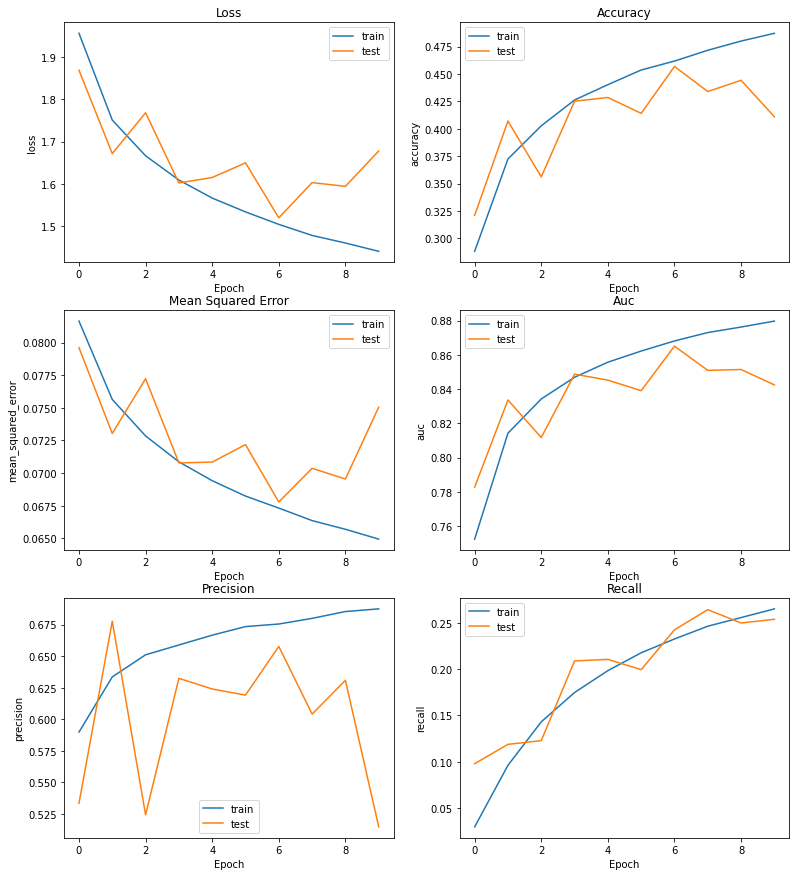

In [18]:
plot_logs(logs1)

In [19]:
generate_report(model1, x_train, y_train, x_test, y_test)

####################### Train Report #######################
1563/1563 [==============================] - 1s 732us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.588654,0.708483,0.404774,0.436272,0.423169,0.446870,0.601287,0.233197,0.667574,0.475760,0.41972,0.498604,0.498604
recall,0.429600,0.432600,0.162800,0.173200,0.317800,0.311200,0.355000,0.875000,0.539400,0.600600,0.41972,0.419720,0.419720
f1-score,0.496705,0.537191,0.232207,0.247960,0.362993,0.366895,0.446429,0.368250,0.596681,0.530941,0.41972,0.418625,0.418625
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.41972,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 888us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.587571,0.697133,0.425974,0.414141,0.437095,0.420373,0.597039,0.229762,0.615839,0.468168,0.411,0.489310,0.489310
recall,0.416000,0.389000,0.164000,0.164000,0.337000,0.293000,0.363000,0.860000,0.521000,0.603000,0.411,0.411000,0.411000
f1-score,0.487119,0.499358,0.236823,0.234957,0.380576,0.345315,0.451493,0.362640,0.564464,0.527098,0.411,0.408984,0.408984
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.411,10000.000000,10000.000000


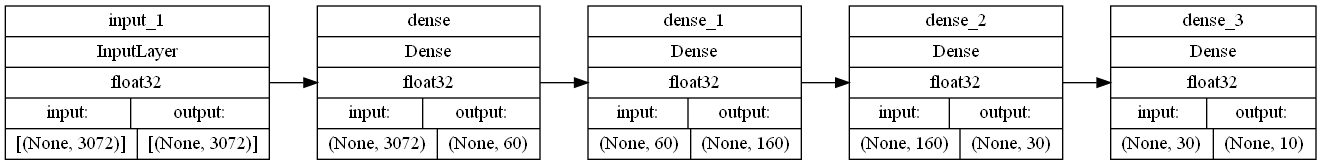

In [20]:
keras.utils.plot_model(model1, show_shapes=True, expand_nested=True, show_dtype=True, rankdir='LR')

## Generate optimum model

It is clear that as datasets are different, we don't want to use previous optimum parameters and we would use configuration below, but we would try that

In [21]:
config2 = {
    'optimizer': keras.optimizers.SGD(learning_rate=0.01),
    'epoch': 10,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [140, 330, 280],
}


In [22]:
model2, logs2 = generate_model(**config2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 140)               430220    
                                                                 
 dense_5 (Dense)             (None, 330)               46530     
                                                                 
 dense_6 (Dense)             (None, 280)               92680     
                                                                 
 dense_7 (Dense)             (None, 10)                2810      
                                                                 
Total params: 572,240
Trainable params: 572,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 1.9041 - accuracy: 0.3131 - mean_squared_error: 0.0801 - auc: 0.7707 - precision_1: 0.6123 - recall_1: 0

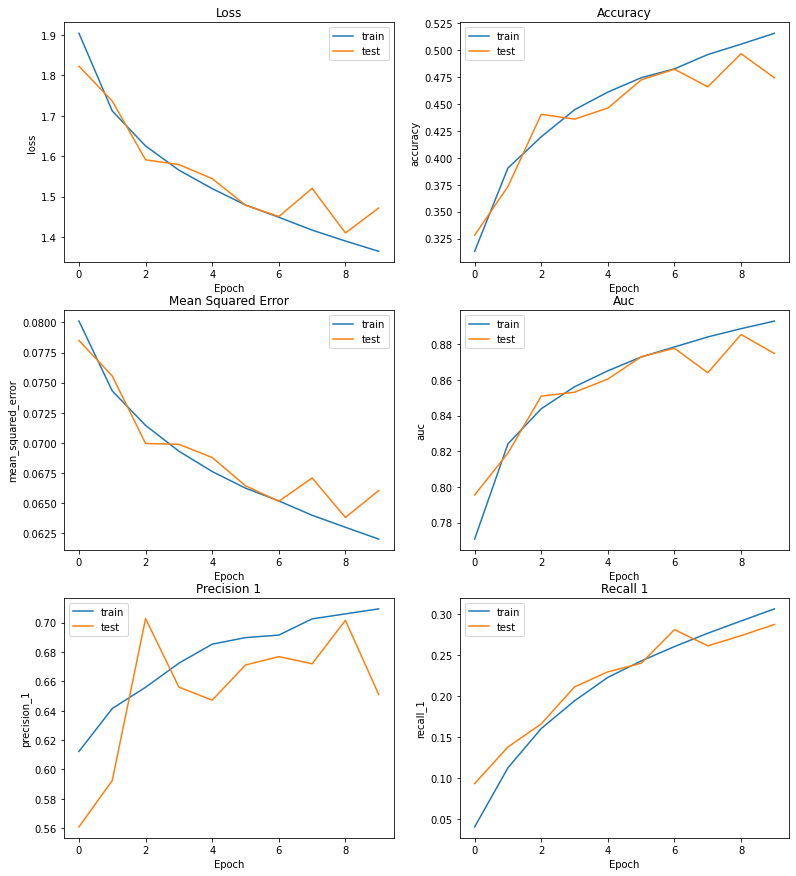

In [23]:
plot_logs(logs2)

In [24]:
generate_report(model2, x_train, y_train, x_test, y_test)

####################### Train Report #######################
1563/1563 [==============================] - 1s 702us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.481189,0.628382,0.313016,0.455663,0.638554,0.381433,0.586044,0.731012,0.767314,0.500572,0.49868,0.548318,0.548318
recall,0.670200,0.664200,0.583400,0.207600,0.190800,0.558800,0.497200,0.440800,0.474200,0.699600,0.49868,0.498680,0.498680
f1-score,0.560181,0.645795,0.407431,0.285243,0.293810,0.453387,0.537979,0.549969,0.586156,0.583584,0.49868,0.490353,0.490353
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.49868,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 715us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.475955,0.601518,0.291221,0.391304,0.591549,0.363140,0.567416,0.697345,0.733542,0.474302,0.4744,0.518729,0.518729
recall,0.673000,0.634000,0.544000,0.180000,0.168000,0.532000,0.505000,0.394000,0.468000,0.646000,0.4744,0.474400,0.474400
f1-score,0.557581,0.617332,0.379358,0.246575,0.261682,0.431643,0.534392,0.503514,0.571429,0.546994,0.4744,0.465050,0.465050
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.4744,10000.000000,10000.000000


### Old model's config

In [25]:
config_old = {
    'optimizer': keras.optimizers.SGD(learning_rate=0.0046),
    'epoch': 15,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [50, 90],
}


In [26]:
_model, _logs = generate_model(**config_old)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                153650    
                                                                 
 dense_9 (Dense)             (None, 90)                4590      
                                                                 
 dense_10 (Dense)            (None, 10)                910       
                                                                 
Total params: 159,150
Trainable params: 159,150
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1563/1563 [==============================] - 2s 1ms/step - loss: 1.9960 - accuracy: 0.2793 - mean_squared_error: 0.0826 - auc: 0.7406 - precision_2: 0.6174 - recall_2: 0.0198 - val_loss: 1.8595 - val_accuracy: 0.3323 - val_mean_squared_error: 0.0788 - val_auc: 0.7869 - val_precision_2: 0.6821 - val_r

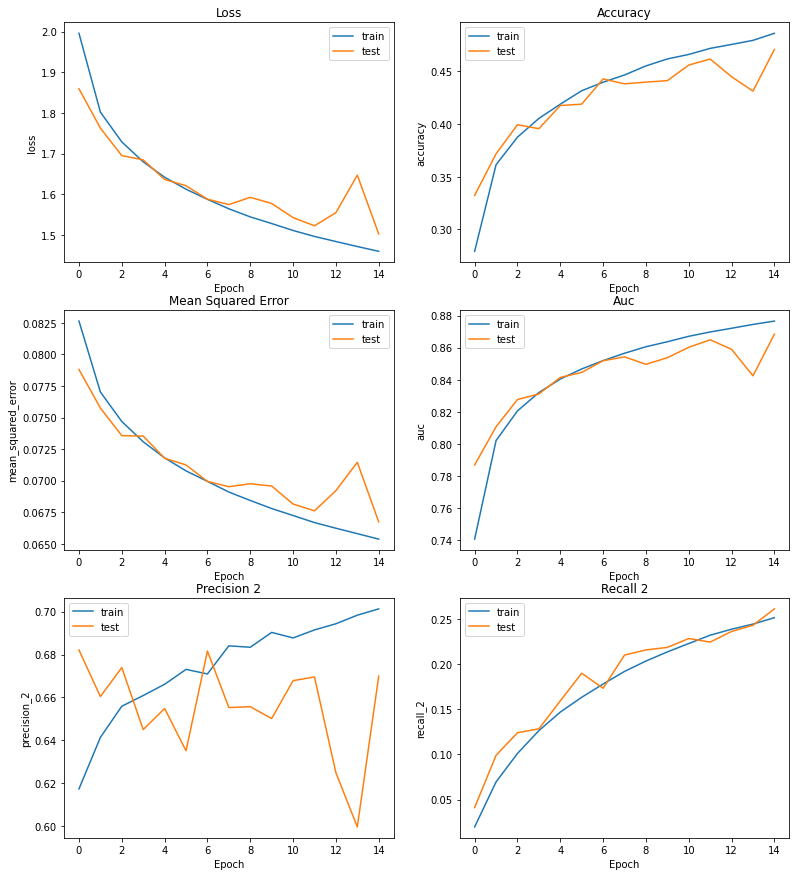

In [27]:
plot_logs(_logs)

In [28]:
del model1, config, logs1, model2, config2, logs2, _model, _logs, config_old

# 03. The effect of different parameters

How to improving our model performance and fine-tuning parameters?

## 01. What is momentum?

***Momentum*** (often referred to as gradient descent with momentum):
- is a optimization algorithm used in deep learning to improve the convergence speed and stability of gradient descent
- the concept of momentum is that previous changes in the weights should influence the current direction of movement in weight space(used in backpropagation step)
- accumulates an exponentially decaying moving average of past gradients and continues to move in their direction
- most useful in optimization problems where the objective function has a large amount of curvature (the gradient may change a lot over relatively small regions of the search space)
- accelerates convergence
    - Momentum accelerates convergence by adding a memory term to the weight update that is proportional to the average of the past gradients
    - having memory allows the optimization to move faster in the direction of the gradient, leading to faster convergence
- reduces oscillations: 
    - Momentum helps to reduce oscillations in the optimization process by smoothing out the weight updates and making them more consistent
    - it also reduces the risk of getting stuck in local minima or saddle points in the optimization process
- Requires Hyperparameter Tuning
    - it requires tuning of the momentum term, typically set to a value between 0 and 1
    - a value close to 1 indicates that the model should have a high momentum and prioritize the previous weight update over the current gradient
    - a value close to 0 indicates that the model should have a low momentum and prioritize the current gradient over the previous weight update
- simple technique that often improves following factors:
    - *training speed*: speed up learning in directions of low curvature without becoming unstable in directions of high curvature
    - *accuracy*
- involves adding an additional hyperparameter that controls the amount of history (momentum) to include in the update equation
    - the value for the hyperparameter is defined in the range 0.0 to 1.0
    - a momentum of 0.0 is the same as gradient descent without momentum
- Gradient descent update **without** momentum:
    - $change(x)_t = StepSize * f'(x)$
- Gradient descent update **with** momentum:
    - $change(x)_t = stepSize * f'(x_{t-1}) + momentum * change(x)_{t-1}$

***
We can increase our model performance by using higher Momentums, but there is a threshold for than and as we would see, using too high momentums could decrease accuracy.
- we got the best performance using $Momentum=0.9$

### 01. Momentum 0.5

In [30]:
_config = {
    'optimizer': keras.optimizers.SGD(learning_rate=0.01, momentum=0.5),
    'epoch': 10,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [140, 330, 280],
}

mm, lg = generate_model(**_config)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 140)               430220    
                                                                 
 dense_13 (Dense)            (None, 330)               46530     
                                                                 
 dense_14 (Dense)            (None, 280)               92680     
                                                                 
 dense_15 (Dense)            (None, 10)                2810      
                                                                 
Total params: 572,240
Trainable params: 572,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8504 - accuracy: 0.3322 - mean_squared_error: 0.0786 - auc: 0.7862 - precision_3: 0.6086 - recall_3: 0

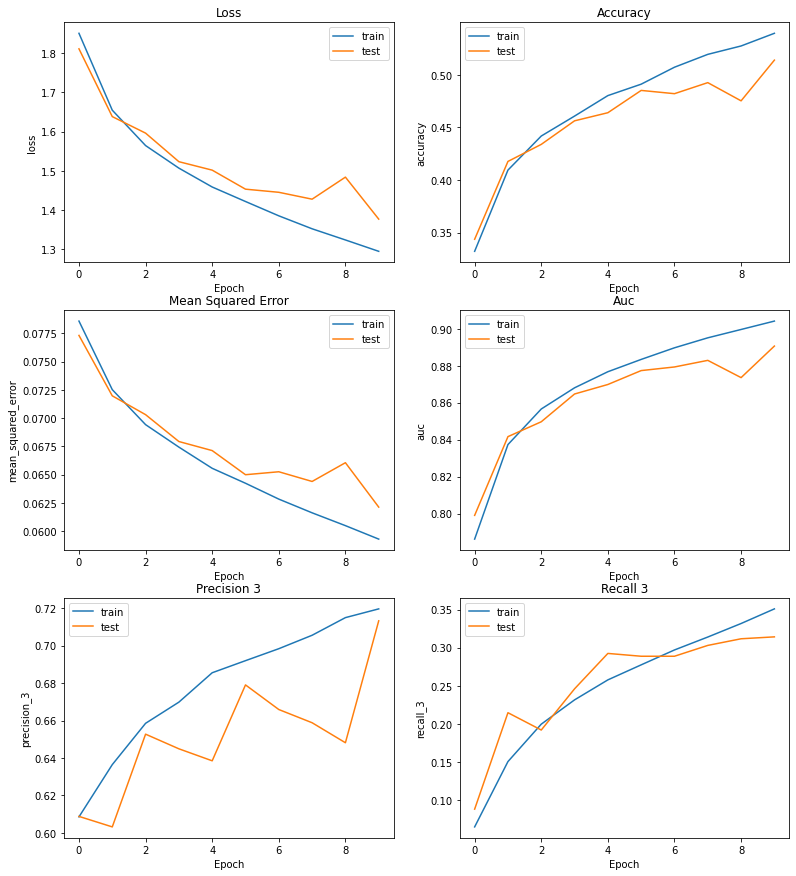

####################### Train Report #######################
1563/1563 [==============================] - 2s 1ms/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.535982,0.655229,0.481902,0.442222,0.453689,0.525108,0.529318,0.717169,0.619915,0.634631,0.56004,0.559517,0.559517
recall,0.671800,0.718000,0.356800,0.358200,0.520200,0.389000,0.664400,0.547200,0.762000,0.612800,0.56004,0.560040,0.560040
f1-score,0.596255,0.685180,0.410021,0.395801,0.484673,0.446921,0.589216,0.620760,0.683653,0.623525,0.56004,0.553600,0.553600
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.56004,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 2ms/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.512100,0.605239,0.420915,0.368165,0.421288,0.482289,0.500000,0.668471,0.571201,0.570539,0.514,0.512021,0.512021
recall,0.656000,0.647000,0.322000,0.303000,0.471000,0.354000,0.625000,0.494000,0.718000,0.550000,0.514,0.514000,0.514000
f1-score,0.575186,0.625423,0.364873,0.332419,0.444759,0.408304,0.555556,0.568143,0.636243,0.560081,0.514,0.507099,0.507099
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.514,10000.000000,10000.000000


In [31]:
plot_logs(lg)
generate_report(mm, x_train, y_train, x_test, y_test)

### 01. Momentum 0.9

In [32]:
_config = {
    'optimizer': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'epoch': 10,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [140, 330, 280],
}

mm, lg = generate_model(**_config)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 140)               430220    
                                                                 
 dense_17 (Dense)            (None, 330)               46530     
                                                                 
 dense_18 (Dense)            (None, 280)               92680     
                                                                 
 dense_19 (Dense)            (None, 10)                2810      
                                                                 
Total params: 572,240
Trainable params: 572,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8667 - accuracy: 0.3221 - mean_squared_error: 0.0792 - auc: 0.7817 - precision_4: 0.5816 - recall_4: 0

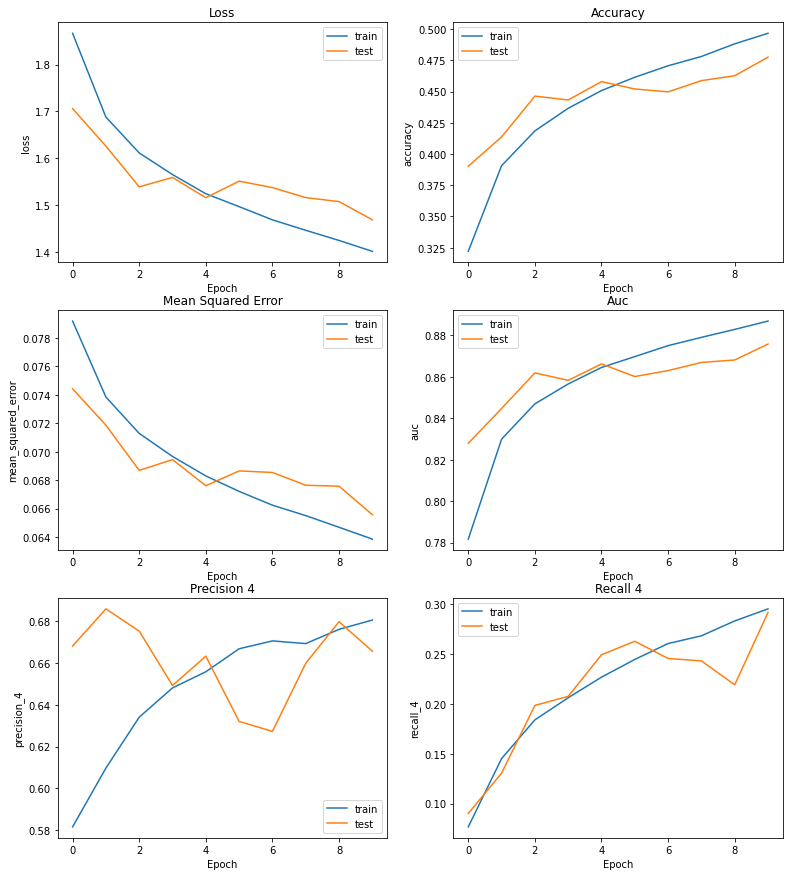

####################### Train Report #######################
1563/1563 [==============================] - 1s 852us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.605070,0.614908,0.556110,0.417018,0.403831,0.411439,0.469989,0.477482,0.717630,0.586577,0.51438,0.526005,0.526005
recall,0.544200,0.694600,0.133800,0.297000,0.510200,0.460400,0.664000,0.693400,0.588600,0.557600,0.51438,0.514380,0.514380
f1-score,0.573023,0.652329,0.215702,0.346922,0.450826,0.434545,0.550398,0.565533,0.646742,0.571722,0.51438,0.500774,0.500774
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.51438,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 1ms/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.569845,0.607607,0.506383,0.327089,0.382616,0.353247,0.442294,0.450167,0.658303,0.559395,0.4776,0.485695,0.485695
recall,0.514000,0.655000,0.119000,0.227000,0.471000,0.408000,0.640000,0.673000,0.551000,0.518000,0.4776,0.477600,0.477600
f1-score,0.540484,0.630414,0.192713,0.268005,0.422232,0.378654,0.523089,0.539479,0.599891,0.537902,0.4776,0.463286,0.463286
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.4776,10000.000000,10000.000000


In [33]:
plot_logs(lg)
generate_report(mm, x_train, y_train, x_test, y_test)

### 01. Momentum 0.98

In [34]:
_config = {
    'optimizer': keras.optimizers.SGD(learning_rate=0.01, momentum=0.98),
    'epoch': 10,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [140, 330, 280],
}

mm, lg = generate_model(**_config)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 140)               430220    
                                                                 
 dense_21 (Dense)            (None, 330)               46530     
                                                                 
 dense_22 (Dense)            (None, 280)               92680     
                                                                 
 dense_23 (Dense)            (None, 10)                2810      
                                                                 
Total params: 572,240
Trainable params: 572,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 2.0463 - accuracy: 0.2274 - mean_squared_error: 0.0848 - auc: 0.7235 - precision_5: 0.4154 - recall_5: 0

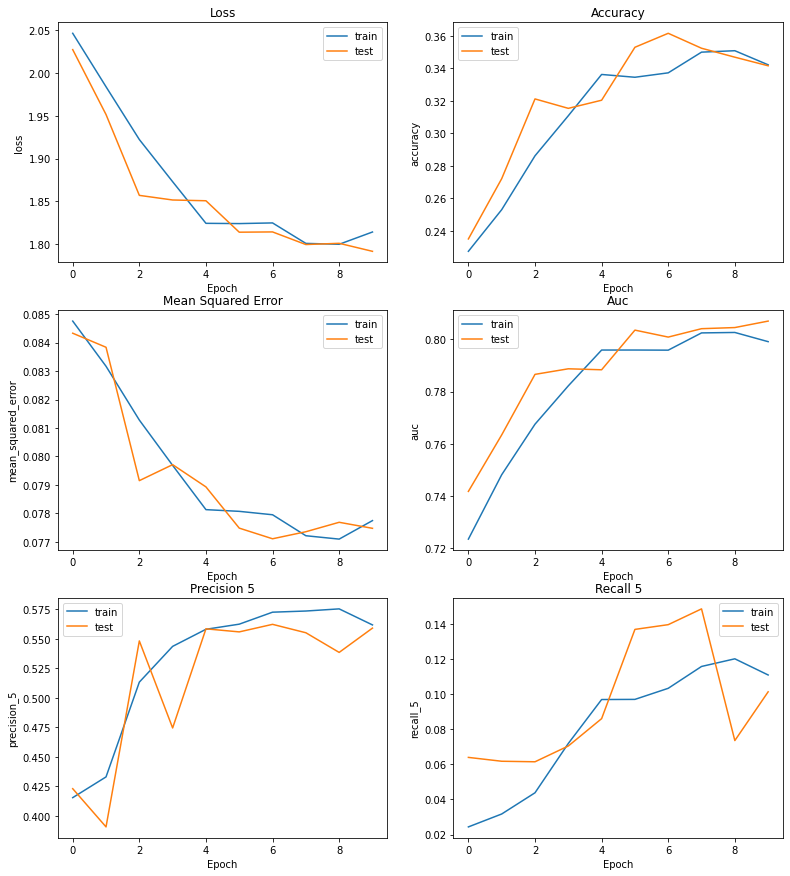

####################### Train Report #######################
1563/1563 [==============================] - 1s 739us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.349364,0.544426,0.242970,0.234052,0.336013,0.234626,0.436643,0.373251,0.323368,0.528283,0.34856,0.360300,0.360300
recall,0.604400,0.394600,0.043200,0.525400,0.284200,0.049600,0.267400,0.554800,0.437000,0.325000,0.34856,0.348560,0.348560
f1-score,0.442784,0.457560,0.073357,0.323841,0.307942,0.081889,0.331679,0.446268,0.371693,0.402427,0.34856,0.323944,0.323944
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.34856,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 792us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.351852,0.538240,0.230366,0.227984,0.359129,0.224719,0.439510,0.354730,0.296507,0.534173,0.3416,0.355721,0.355721
recall,0.627000,0.373000,0.044000,0.510000,0.297000,0.040000,0.287000,0.525000,0.416000,0.297000,0.3416,0.341600,0.341600
f1-score,0.450755,0.440638,0.073887,0.315107,0.325123,0.067912,0.347247,0.423387,0.346234,0.381748,0.3416,0.317204,0.317204
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.3416,10000.000000,10000.000000


In [35]:
plot_logs(lg)
generate_report(mm, x_train, y_train, x_test, y_test)

### Could we improve model performance by increasing momentum?

- In most cases, using momentum gives you faster training and better predictive accuracy
- However, in some situations, using no momentum (equal to0.0) leads to better results than using momentum



In [36]:
del mm, lg, _config

## 02. Using Adam as optimizer

As we can see, using this optimization function, we could reach to a higher accuracy thad using *SGD* without momentum.

In [37]:
_config = {
    'optimizer': keras.optimizers.Adam(learning_rate=0.001),
    'epoch': 10,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [140, 330, 280],
}

am, lg = generate_model(**_config)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 140)               430220    
                                                                 
 dense_25 (Dense)            (None, 330)               46530     
                                                                 
 dense_26 (Dense)            (None, 280)               92680     
                                                                 
 dense_27 (Dense)            (None, 10)                2810      
                                                                 
Total params: 572,240
Trainable params: 572,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8501 - accuracy: 0.3282 - mean_squared_error: 0.0788 - auc: 0.7864 - precision_6: 0.5841 - recall_6: 0

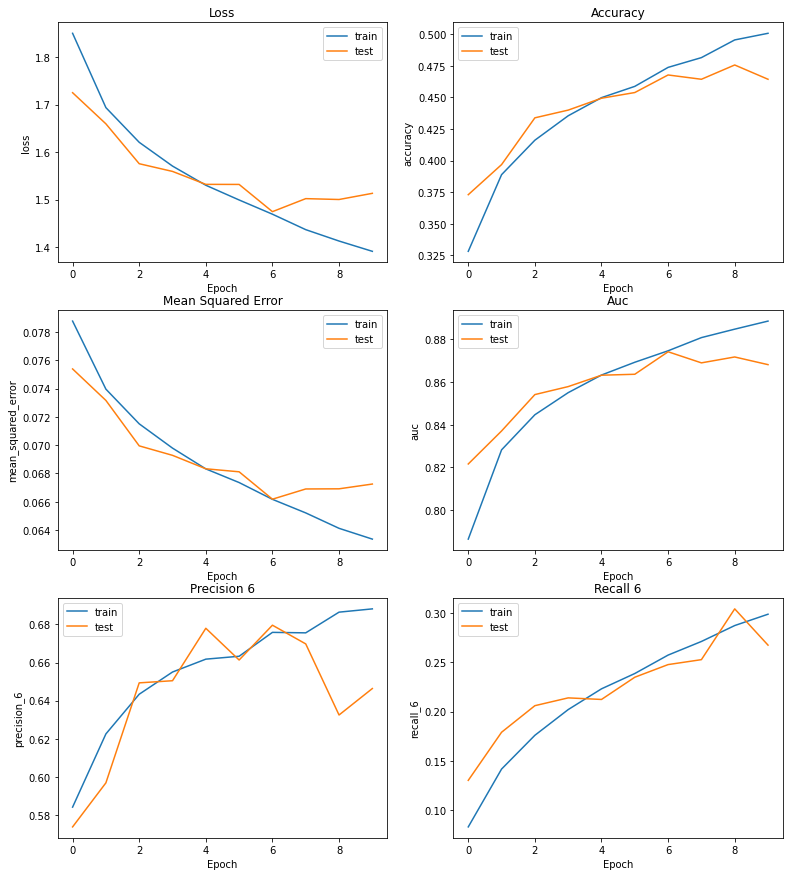

####################### Train Report #######################
1563/1563 [==============================] - 2s 967us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.654746,0.648176,0.398198,0.389029,0.511620,0.436669,0.455456,0.641331,0.503330,0.491993,0.50166,0.513055,0.513055
recall,0.380800,0.593600,0.397800,0.339000,0.295000,0.420600,0.663600,0.516400,0.770800,0.639000,0.50166,0.501660,0.501660
f1-score,0.481538,0.619689,0.397999,0.362296,0.374223,0.428484,0.540171,0.572125,0.608991,0.555942,0.50166,0.494146,0.494146
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.50166,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 949us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.606612,0.620614,0.351833,0.314836,0.499076,0.393040,0.435724,0.574843,0.465674,0.480096,0.4643,0.474235,0.474235
recall,0.367000,0.566000,0.355000,0.278000,0.270000,0.384000,0.644000,0.457000,0.719000,0.603000,0.4643,0.464300,0.464300
f1-score,0.457321,0.592050,0.353410,0.295273,0.350422,0.388467,0.519774,0.509192,0.565252,0.534574,0.4643,0.456574,0.456574
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.4643,10000.000000,10000.000000


In [38]:
plot_logs(lg)
generate_report(am, x_train, y_train, x_test, y_test)

In [39]:
del am, lg, _config

## 03. What about Epoch?

- An epoch in machine learning refers to a complete iteration over the entire training dataset
- During an epoch, the model processes the entire training dataset, updating its weights and biases based on the calculated loss
- Using too many epochs can lead to overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data
- Using too few epochs can result in underfitting, where the model does not learn the underlying patterns in the data well enough
- It is a key concept in machine learning, and the number of epochs to use is an important hyperparameter that needs to be carefully considered when training a model

Les't try two cases:
- high epoch
- low epoch

***
There is a tradeoff between using high epoch sizes and overfitting model or using low epochs and underfitting:
- Using low values for epoch, could cause ***underfitting***:
    - it can't reach the minimum loss
    - it can't capture the underlying trend of the data
- Using high values for epoch, could cause ***overfitting***:
    - model performs poorly on test(validation data)
    - it reaches to a high accuracy value for training data
    - it captures the noise in the data
- As a general instruction:
    - the number of epochs to use is a hyperparameter that needs to be set in advance, and can be determined through experimentation or using techniques such as early stopping
    - choosing different epoch sizes
    - train and test our model using above epochs
    - choosing the best model (or maybe we added new epoch sizes and try them before selecting final model)
    - optimum value usually depends on training data size and network structure1


So, we can't always increasing epoch size and expecting better performance.
To prevent overfitting, you may:
- Use early-stopping: using a hold-on set (validation set) and measure model performance on that for each epoch, then stop training process when score degrades.
- Change the network complexity
- Using regularization (explained later)

### 01. High Epoch

In [40]:
_config = {
    'optimizer': keras.optimizers.Adam(learning_rate=0.001),
    'epoch': 100,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [140, 330, 280],
}

em, lg = generate_model(**_config)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 140)               430220    
                                                                 
 dense_29 (Dense)            (None, 330)               46530     
                                                                 
 dense_30 (Dense)            (None, 280)               92680     
                                                                 
 dense_31 (Dense)            (None, 10)                2810      
                                                                 
Total params: 572,240
Trainable params: 572,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8451 - accuracy: 0.3275 - mean_squared_error: 0.0786 - auc: 0.7879 - precision_7: 0.5805 - recall_7: 

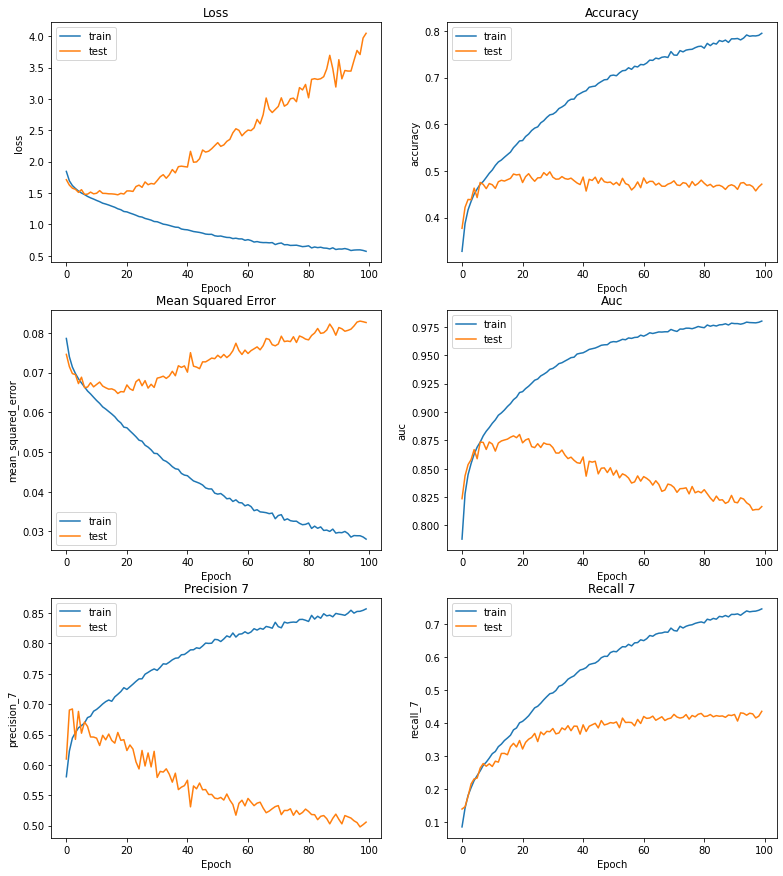

In [41]:
plot_logs(lg)
# generate_report(em, x_train, y_train, x_test, y_test)

### 01. Low Epoch

In [42]:
_config = {
    'optimizer': keras.optimizers.Adam(learning_rate=0.001),
    'epoch': 4,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [140, 330, 280],
}

em, lg = generate_model(**_config)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 140)               430220    
                                                                 
 dense_33 (Dense)            (None, 330)               46530     
                                                                 
 dense_34 (Dense)            (None, 280)               92680     
                                                                 
 dense_35 (Dense)            (None, 10)                2810      
                                                                 
Total params: 572,240
Trainable params: 572,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8582 - accuracy: 0.3198 - mean_squared_error: 0.0790 - auc: 0.7841 - precision_8: 0.5793 - recall_8: 0.

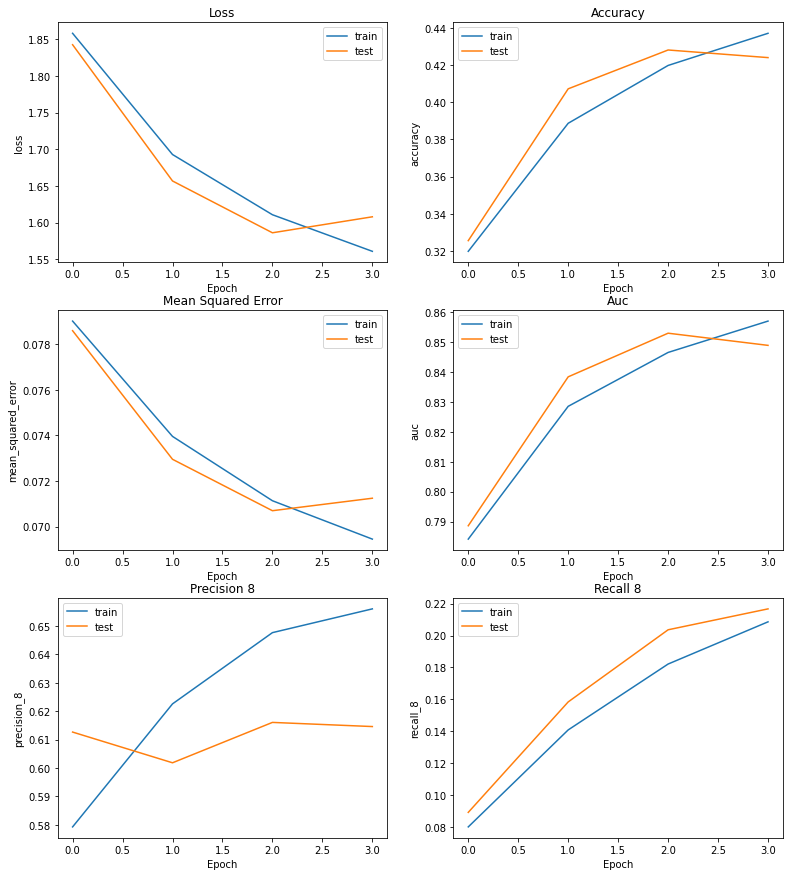

In [43]:
plot_logs(lg)
# generate_report(em, x_train, y_train, x_test, y_test)

In [44]:
del em, lg, _config

## 04. Loss function



### 01. what if we used `MSE` instead of `categorical cross entropy`?

As we can see, `MSE` wasn't a good choice:
- in this way, we imagined normal distribution; however, imagine we had two classes; in this way, we have Bernoulli distribution.
    - we usually use **categorical cross entropy** for classification and **MSE** for regression
- it is not guaranteed that `MSE` could minimize the Cost function 
    - because MSE function expects real-valued $inputs \in [-∞, ∞]$, but, binary classification models output $`probabilities \in (0,1)$ through the sigmoid/logistic function
- `MSE` usually used for regression problem
- `MSE` treats the outputs as continuous values and calculates the average squared difference between the predicted and actual values
- classification problems require a loss function that can distinguish between the different classes and penalize incorrect predictions
    - using MSE in classification can lead to suboptimal results for classification problems, as the model may not produce probabilistic outputs or be able to distinguish between classes
- `Cross entropy` loss measures the distance between the predicted probabilities and the true probabilities, and penalizes the model more severely for incorrect predictions
- in conclusion, `MSE` is not a suitable loss function for classification problems, and `cross entropy` loss should be used instead

In [45]:
_config = {
    'optimizer': keras.optimizers.Adam(learning_rate=0.001),
    'epoch': 10,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.LeakyReLU(alpha=0.01), 
                   keras.layers.LeakyReLU(alpha=0.01)],
    'units': [140, 330, 280],
}

fm, lg = generate_model(**_config, loss_f=keras.losses.mean_squared_error)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 140)               430220    
                                                                 
 dense_37 (Dense)            (None, 330)               46530     
                                                                 
 dense_38 (Dense)            (None, 280)               92680     
                                                                 
 dense_39 (Dense)            (None, 10)                2810      
                                                                 
Total params: 572,240
Trainable params: 572,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0803 - accuracy: 0.3048 - mean_squared_error: 0.0803 - auc: 0.7653 - precision_9: 0.5755 - recall_9: 0

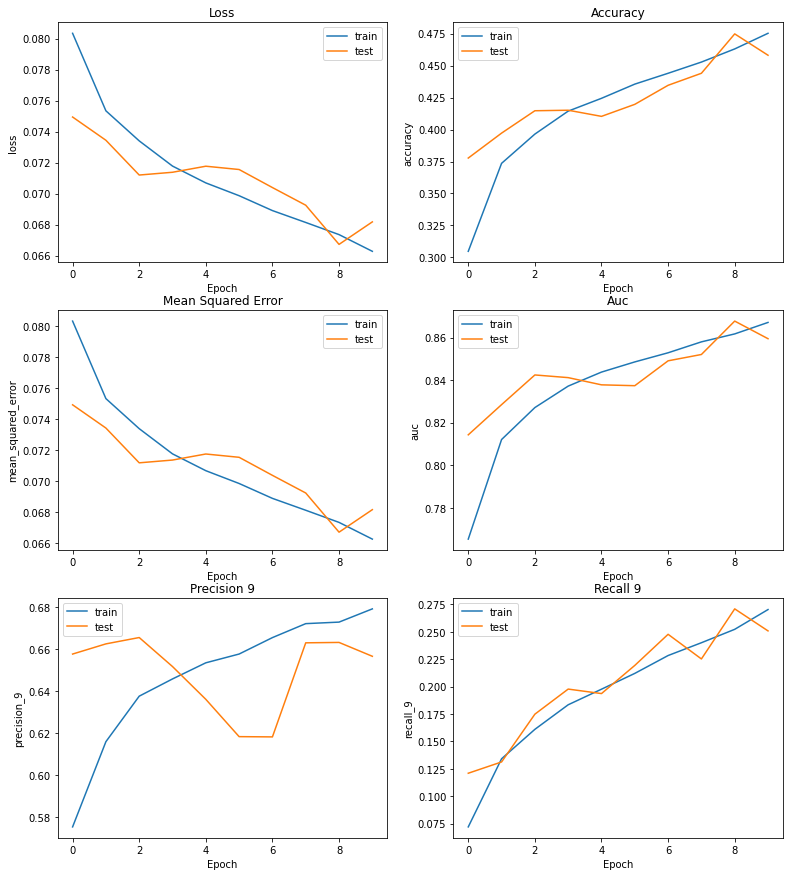

####################### Train Report #######################
1563/1563 [==============================] - 1s 704us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.695245,0.555065,0.387464,0.336541,0.536585,0.362985,0.458550,0.527471,0.589232,0.525745,0.48632,0.497488,0.497488
recall,0.371400,0.653200,0.353600,0.307800,0.272800,0.486400,0.580800,0.591400,0.702600,0.543200,0.48632,0.486320,0.486320
f1-score,0.484161,0.600147,0.369758,0.321529,0.361708,0.415726,0.512486,0.557609,0.640941,0.534330,0.48632,0.479840,0.479840
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.48632,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 763us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.679924,0.541843,0.335463,0.307525,0.518847,0.327881,0.442308,0.486339,0.573099,0.503568,0.4581,0.471680,0.471680
recall,0.359000,0.641000,0.315000,0.282000,0.234000,0.461000,0.575000,0.534000,0.686000,0.494000,0.4581,0.458100,0.458100
f1-score,0.469895,0.587265,0.324910,0.294210,0.322536,0.383209,0.500000,0.509056,0.624488,0.498738,0.4581,0.451431,0.451431
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.4581,10000.000000,10000.000000


In [46]:
plot_logs(lg)
generate_report(fm, x_train, y_train, x_test, y_test)

In [47]:
del fm, lg, _config

## 05. Regularization

***Regularization***'s methods used to prevent network from overfitting and improve the generalization performance of a model. one of this method is ***Dropout***:
- during training, some number of layer outputs are randomly ignored or "dropped out"
- this has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer
    - so, each update to a layer during training is performed with a different "view" of the configured layer.
- this approach is like making the training process noisy and forcing nodes within a layer, having more or less participation
- it can doubled the number of iterations required to converge
- this approach could improve our resistance, so, could model would lose much performance in noisy situations

As we can see, this approach could prevent from overfitting, weather required higher epoch to converge

***
**Regularization** methods:
- L1 Regularization (Lasso): This method adds a penalty term equal to the absolute value of the weights to the loss function.
    - L1 regularization tends to produce sparse models, where many weights are set to zero, effectively removing unimportant features.
- L2 Regularization (Ridge): This method adds a penalty term equal to the square of the weights to the loss function.
    - L2 regularization tends to produce models with small, non-zero weights, effectively reducing the magnitude of the weights.
- Dropout: This method randomly sets a fraction of the neurons in the network to zero during each training iteration. 
    - Dropout forces the network to learn multiple, redundant representations of the data, making it less likely to overfit.
- Early Stopping: This method stops the training process when the model's performance on a validation set stops improving.
    - Early stopping effectively limits the number of epochs and reduces the risk of overfitting.
- Data Augmentation: This method creates new training samples by applying transformations to the original training samples.
    - This method increases the size and diversity of the training data, reducing the risk of overfitting.


In [48]:
_config = {
    'optimizer': keras.optimizers.Adam(learning_rate=0.001),
    'epoch': 10,
    'batch_size': 32,
    'activation': [keras.layers.LeakyReLU(alpha=0.02), keras.layers.Dropout(rate=0.1),
                   keras.layers.LeakyReLU(alpha=0.01), keras.layers.Dropout(rate=0.1),
                   ],
    'units': [140, None, 330, None],
}

rm, lg = generate_model(**_config)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 140)               430220    
                                                                 
 dropout (Dropout)           (None, 140)               0         
                                                                 
 dense_41 (Dense)            (None, 330)               46530     
                                                                 
 dropout_1 (Dropout)         (None, 330)               0         
                                                                 
 dense_42 (Dense)            (None, 10)                3310      
                                                                 
Total params: 480,060
Trainable params: 480,060
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [=========================

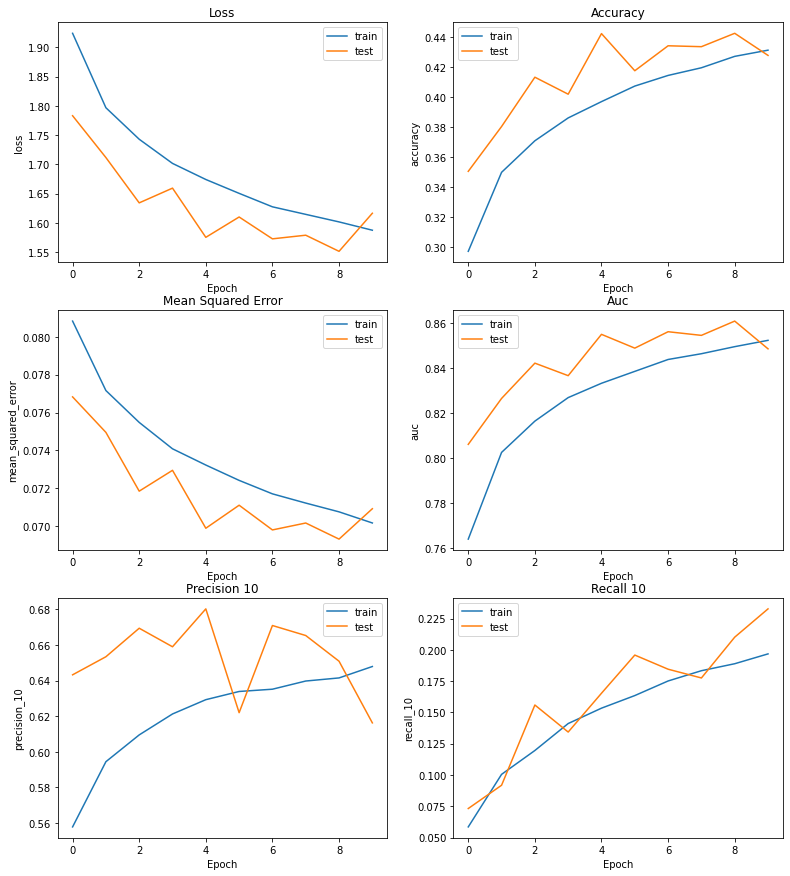

####################### Train Report #######################
1563/1563 [==============================] - 1s 908us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.422013,0.612088,0.360271,0.443382,0.354948,0.465413,0.368780,0.408803,0.642624,0.475554,0.43952,0.455388,0.455388
recall,0.582800,0.494200,0.138200,0.120600,0.480600,0.262400,0.670000,0.633400,0.472200,0.540800,0.43952,0.439520,0.439520
f1-score,0.489542,0.546863,0.199769,0.189623,0.408326,0.335593,0.475717,0.496901,0.544386,0.506083,0.43952,0.419280,0.419280
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.43952,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 904us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.403974,0.607277,0.335092,0.389091,0.342163,0.457529,0.365054,0.396322,0.616095,0.480322,0.4277,0.439292,0.439292
recall,0.549000,0.484000,0.127000,0.107000,0.465000,0.237000,0.679000,0.625000,0.467000,0.537000,0.4277,0.427700,0.427700
f1-score,0.465451,0.538676,0.184191,0.167843,0.394235,0.312253,0.474825,0.485060,0.531286,0.507082,0.4277,0.406090,0.406090
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.4277,10000.000000,10000.000000


In [49]:
plot_logs(lg)
generate_report(rm, x_train, y_train, x_test, y_test)

Let's change this config ti use higher epoch.

In [50]:
_config['epoch'] = 50

rm, lg = generate_model(**_config)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 140)               430220    
                                                                 
 dropout (Dropout)           (None, 140)               0         
                                                                 
 dense_44 (Dense)            (None, 330)               46530     
                                                                 
 dropout_1 (Dropout)         (None, 330)               0         
                                                                 
 dense_45 (Dense)            (None, 10)                3310      
                                                                 
Total params: 480,060
Trainable params: 480,060
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1563/1563 [=========================

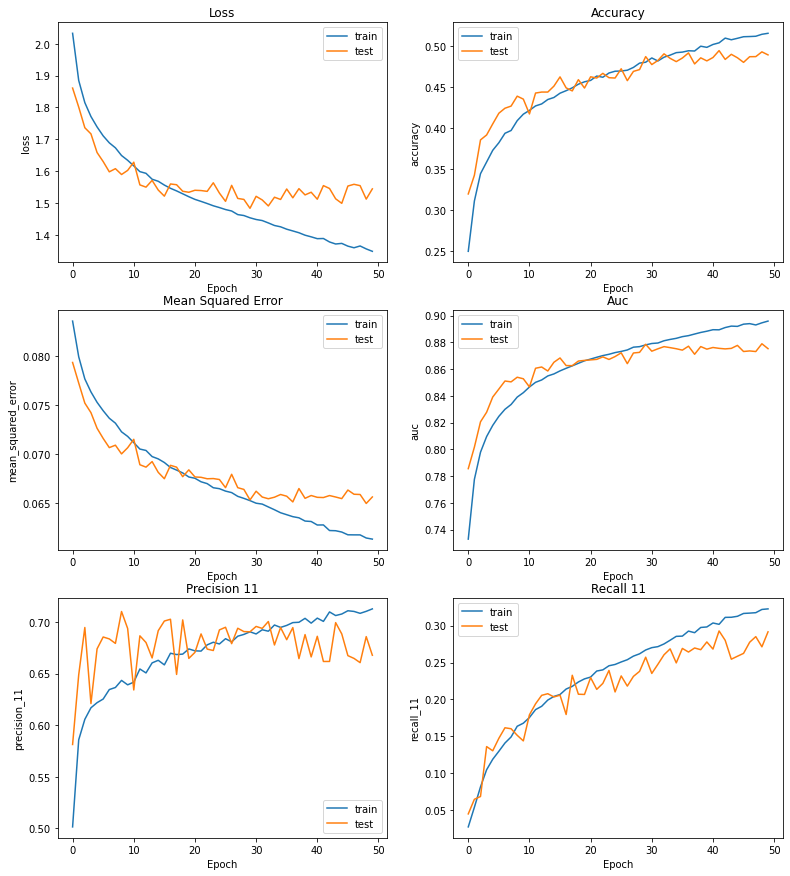

####################### Train Report #######################
1563/1563 [==============================] - 1s 752us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.614128,0.712714,0.429874,0.461575,0.424865,0.634435,0.613449,0.627447,0.576669,0.543185,0.55596,0.563834,0.563834
recall,0.533800,0.648000,0.415000,0.386800,0.550200,0.311000,0.565600,0.653800,0.786000,0.709400,0.55596,0.555960,0.555960
f1-score,0.571153,0.678818,0.422306,0.420892,0.479477,0.417394,0.588554,0.640353,0.665256,0.615265,0.55596,0.549947,0.549947
support,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.55596,50000.000000,50000.000000


####################### Test Report ########################
313/313 [==============================] - 0s 753us/step


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.578631,0.628308,0.366226,0.361827,0.377134,0.534836,0.553965,0.542969,0.518047,0.498829,0.4896,0.496077,0.496077
recall,0.482000,0.546000,0.360000,0.309000,0.508000,0.261000,0.503000,0.556000,0.732000,0.639000,0.4896,0.489600,0.489600
f1-score,0.525914,0.584270,0.363086,0.333333,0.432893,0.350806,0.527254,0.549407,0.606714,0.560281,0.4896,0.483396,0.483396
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.4896,10000.000000,10000.000000


In [51]:
plot_logs(lg)
generate_report(rm, x_train, y_train, x_test, y_test)

In [52]:
del rm, lg, _config,